In [1]:
!git clone https://github.com/nicola-decao/s-vae-pytorch.git

Cloning into 's-vae-pytorch'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 107 (delta 0), reused 5 (delta 0), pack-reused 98
Receiving objects: 100% (107/107), 29.69 KiB | 4.95 MiB/s, done.
Resolving deltas: 100% (40/40), done.


In [2]:
!python s-vae-pytorch/setup.py install

running install
/usr/local/lib/python3.9/dist-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating hyperspherical_vae.egg-info
writing hyperspherical_vae.egg-info/PKG-INFO
writing dependency_links to hyperspherical_vae.egg-info/dependency_links.txt
writing requirements to hyperspherical_vae.egg-info/requires.txt
writing top-level names to hyperspherical_vae.egg-info/top_level.txt
writing manifest file 'hyperspherical_vae.egg-info/SOURCES.txt'
reading manifest file 'hyperspherical_vae.egg-info/SOURCES.txt'
writing manifest file 'hyperspherical_vae.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x8

In [3]:
!pip install scanpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 11.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.1/96.1 KB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 65.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 KB 7.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82830 sha256=003df4403150e17b9889766c3b267a48f50ad1b4fd30d5a2cdf919cd47b85482
  Stored in directory: /root/.cache/pip/wheels/f4/3e/1c/596d0a463d17475af648688443fa4846fef624d1390339e7e9
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8042 sha256=04e54b834d4ac9594e

In [4]:
!pip3 install bbknn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 648.0/648.0 KB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.1-cp39-cp39-linux_x86_64.whl size=582307 sha256=23cfb04c53056edc2e4705f3f7270dd88f04df8ca2feba4c7895055779f5ade7
  Stored in directory: /root/.cache/pip/wheels/5b/7d/31/9a9a4993d085bc85bee21946bce94cd5906ce99730f5467e57
Successfully built annoy


In [5]:
import sys as sys
print(sys.path)

sys.path.append("/content/s-vae-pytorch")

['/content', '/env/python', '/usr/lib/python39.zip', '/usr/lib/python3.9', '/usr/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.9/dist-packages/IPython/extensions', '/root/.ipython']


In [6]:
import numpy as np
import os as os
import scanpy as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets, transforms
from collections import defaultdict

from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform

In [7]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.10.1 pandas==1.4.4 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


In [8]:
def read_data(filename):
  adata = sc.read_h5ad(filename)
  return adata

In [9]:
file_path = "./drive/MyDrive/immune_cell_dataset/"
# data can be myeloid, b_cells, or t_cells
data = "t_cells"
file_path = os.path.join(file_path, data)
if data == "myeloid":
  filename = "myeloid.h5ad"
elif data == "b_cells":
  filename = "b-cells.h5ad"
else:
  filename = "t-cells.h5ad"
file_path = os.path.join(file_path, filename)

adata = read_data(file_path)

In [10]:
# adata.X is the cell by gene matrix
# myeloid is 51,52 x 36,601
# t_cells is 216,611 x 36,601
# b_cells is 54,934 x 36,601
# dtype is float 32
adata.X.shape

(216611, 36601)

Data preprocessing

In [11]:
# Select highly variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
print(adata.X.shape)
# Scale to unit variance and zero mean
sc.pp.scale(adata)

extracting highly variable genes
    finished (0:00:19)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
(216611, 1252)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


Get rid of batch effects

In [12]:
import bbknn

bbknn.ridge_regression(adata, batch_key=['Chemistry'])

computing ridge regression
	finished: `.X` now features regression residuals
	`.layers['X_explained']` stores the expression explained by the technical effect (0:00:12)


Small dataset below just for testing purposes

In [19]:
!mkdir data

In [20]:
!mkdir data/filtered_gene_bc_matrices

In [21]:
!mkdir data/filtered_gene_bc_matrices/hg19

In [22]:
adata = sc.read_10x_mtx(
    'data/filtered_gene_bc_matrices/hg19/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


In [23]:
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

In [24]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

In [25]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [26]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

In [27]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [28]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.9/dist-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [29]:
sc.pp.log1p(adata)

In [30]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [31]:
adata.raw = adata

In [32]:
adata = adata[:, adata.var.highly_variable]

In [33]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:10)


In [34]:
sc.pp.scale(adata, max_value=10)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


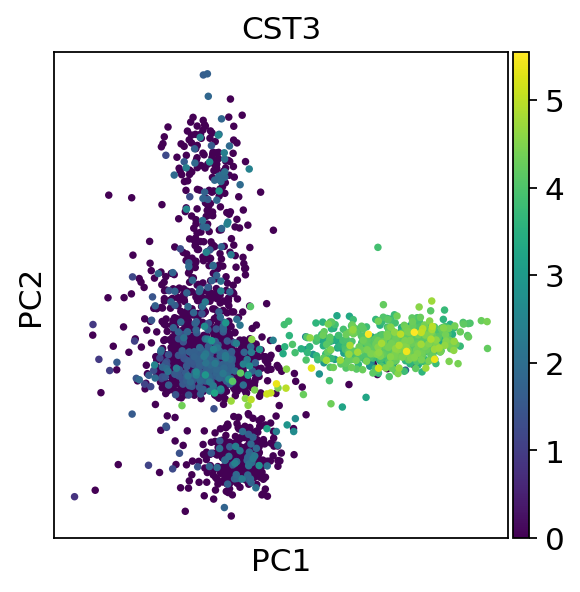

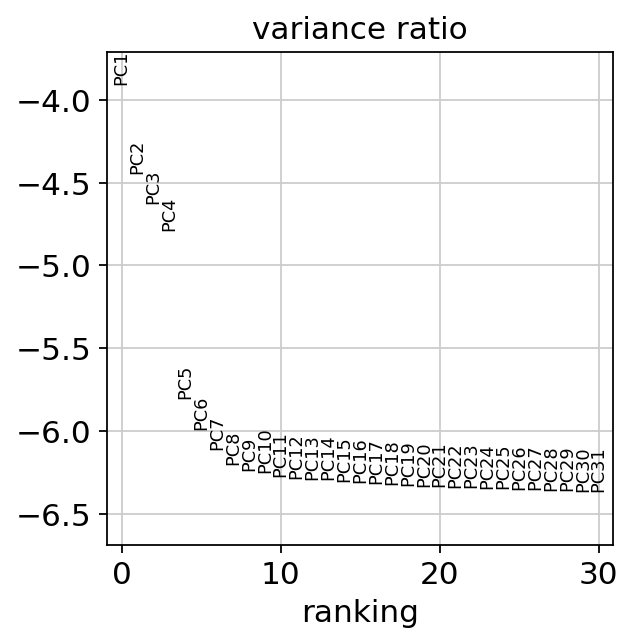

In [35]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

In [36]:
# Originally 2700 x 32738
# After preprocessing, 2638 x 1838
adata.X.shape

(2638, 1838)

Hyperspherical VAE

Model

In [88]:
class ModelVAE(torch.nn.Module):
    
    def __init__(self, n_gene, z_dim=2,
                 encoder_layer=None, decoder_layer=None, activation=F.relu,
                 distribution='normal', x=None):
        """
        ModelVAE initializer
        :param z_dim: dimension of the latent representation
        :encoder_layer: a list containing the units of each layer in the encoder
        :decoder_layer: a list containing the units of each layer in the decoder
        :param activation: callable activation function
        :param distribution: string either `normal` or `vmf`, indicates which distribution to use
        """
        super(ModelVAE, self).__init__()
        
        if encoder_layer is None:
          encoder_layer = [128, 64, 32]
        self.encoder_layer = [nn.Linear(n_gene, encoder_layer[0])]
        for i in range(1, len(encoder_layer)):
            self.encoder_layer.append(nn.Linear(encoder_layer[i-1], encoder_layer[i]))
        self.encoder_layer = nn.ModuleList(self.encoder_layer)
        
        if decoder_layer is None:
          decoder_layer = [32, 128]
        self.decoder_layer = [nn.Linear(z_dim, decoder_layer[0])]
        for i in range(1, len(decoder_layer)):
          self.decoder_layer.append(nn.Linear(decoder_layer[i-1], decoder_layer[i]))
        self.decoder_layer = nn.ModuleList(self.decoder_layer)

        if distribution == "normal":
          # Output of encoder
          self.fc_mean = nn.Linear(encoder_layer[-1], z_dim)
          self.fc_var = nn.Linear(encoder_layer[-1], z_dim)
          # Output of decoder
          self.mu_layer = nn.Linear(decoder_layer[-1], n_gene)
          self.var_layer = nn.Linear(decoder_layer[-1], n_gene)
        elif distribution == "vmf":
          # Output of encoder
          self.fc_mean = nn.Linear(encoder_layer[-1], z_dim)
          self.fc_var = nn.Linear(encoder_layer[-1], 1)
          # Output of decoder
          self.mu_layer = nn.Linear(decoder_layer[-1], n_gene)
          self.var_layer = nn.Linear(decoder_layer[-1], n_gene)
        else:
          raise NotImplemented

        self.z_dim, self.activation, self.distribution = z_dim, activation, distribution
        self.n_input_feature = n_gene

    def encode(self, x):
        # regularizer = torch.
        
        h = self.encoder_layer[0](x)
        h = self.activation(h)
        # Add in batch normalization here
        for i in range(1, len(self.encoder_layer)):
          h = self.encoder_layer[i](h)
          h = self.activation(h)
          # Add in batch normalization here

        if self.distribution == 'normal':
            # compute mean and std of the normal distribution
            z_mean = self.fc_mean(h)
            z_var = F.softplus(self.fc_var(h))
        elif self.distribution == 'vmf':
            # compute mean and concentration of the von Mises-Fisher
            z_mean = self.fc_mean(h)
            z_mean = z_mean / z_mean.norm(dim=-1, keepdim=True)
            # the `+ 1` prevent collapsing behaviors
            z_var = F.softplus(self.fc_var(h)) + 1
        else:
            raise NotImplemented
        
        return z_mean, z_var
        
    def decode(self, z):
        # l2 regularization goes here

        h = self.decoder_layer[0](z)
        h = self.activation(h)
        # Add in batch normalization here
        for i in range(1, len(self.decoder_layer)):
          h = self.decoder_layer[i](h)
          h = self.activation(h)
          # Add in batch normalization here

        mu = self.mu_layer(h)
        sigma_square = F.softplus(self.var_layer(h))
        sigma_sqare = torch.clip(sigma_square, 1e-6, 1e10)
        return mu, sigma_square
        
    def reparameterize(self, z_mean, z_var):
        if self.distribution == 'normal':
            q_z = torch.distributions.normal.Normal(z_mean, z_var)
            p_z = torch.distributions.normal.Normal(torch.zeros_like(z_mean), torch.ones_like(z_var))
        elif self.distribution == 'vmf':
            q_z = VonMisesFisher(z_mean, z_var)
            p_z = HypersphericalUniform(self.z_dim - 1)
        else:
            raise NotImplemented

        return q_z, p_z
        
    def forward(self, x): 
        z_mean, z_var = self.encode(x)
        q_z, p_z = self.reparameterize(z_mean, z_var)
        z = q_z.rsample()
        mu_, sigma_square_ = self.decode(z)
        return (z_mean, z_var), (q_z, p_z), z, mu_, sigma_square_

Log likelihood

In [39]:
# def log_likelihood(model, x, n=10):
    # """
    # :param model: model object
    # :param optimizer: optimizer object
    # :param n: number of MC samples
    # :return: MC estimate of log-likelihood
    # """
    # z_mean, z_var = model.encode(x)
    # q_z, p_z = model.reparameterize(z_mean, z_var)
    # z = q_z.rsample(torch.Size([n]))
    # mu_, sigma_square_ = model.decode(z)

    # log_p_z = p_z.log_prob(z)

    # if model.distribution == 'normal':
        # log_p_z = log_p_z.sum(-1)

    # log_p_x_z = -nn.BCEWithLogitsLoss(reduction='none')(x_mb_, x.reshape(-1, 784).repeat((n, 1, 1))).sum(-1)
    # log_p_x_z = log_likelihood_nb(x, mu_, sigma_square_).sum(-1)

    # log_q_z_x = q_z.log_prob(z)

    # if model.distribution == 'normal':
        # log_q_z_x = log_q_z_x.sum(-1)

    # return ((log_p_x_z + log_p_z - log_q_z_x).t().logsumexp(-1) - np.log(n)).mean()

In [40]:
def log_likelihood(model, x, n=10):
  z_mean, z_var = model.encode(x)
  q_z, p_z = model.reparameterize(z_mean, z_var)
  z = q_z.rsample(torch.Size([n]))
  mu_, sigma_square_ = model.decode(z)

  # In scPhere used tf.reduce_mean()
  return torch.mean(log_likelihood_student(x, mu_, sigma_square_, df=2.0))

In [41]:
def log_likelihood_nb(x, mu, sigma, eps=1e-16):

    log_mu_sigma = torch.log(mu + sigma + eps)

    ll = torch.lgamma(x + sigma) - torch.lgamma(sigma) - \
        torch.lgamma(x + 1) + sigma * torch.log(sigma + eps) - \
        sigma * log_mu_sigma + x * torch.log(mu + eps) - x * log_mu_sigma

    return torch.mean(ll, dim=-1)

In [42]:
def log_likelihood_student(x, mu, sigma_square, df=2.0):
    sigma = torch.sqrt(sigma_square)
    
    dist = torch.distributions.studentT.StudentT(df=df,
                                             loc=mu,
                                             scale=sigma)
    
    # return tf.reduce_sum(dist.log_prob(x), reduction_indices=1)
    return torch.mean(dist.log_prob(x), dim=1)

Training and testing

In [47]:
def train(model, optimizer):
    # for i, (x_mb, y_mb) in enumerate(train_loader):
    for i in range(0, X.shape[0], 128):
    # for x in X:
            if i+128 < X.shape[0]:
              x = X[i: i+128, :]
            else:
              x = X[i:, :]
            optimizer.zero_grad()
            
            # dynamic binarization
            # x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape)).float()

            # _, (q_z, p_z), _, x_mb_ = model(x_mb.reshape(-1, 784))
            (z_mean, z_var), (q_z, p_z), _, mu, sigma_square = model(x)
            
            # loss_recon = nn.BCEWithLogitsLoss(reduction='none')(x_reconstructed, x).sum(-1).mean()
            # loss_recon = log_likelihood(x, z_mean, z_var)
            # library_size = torch.sum(x, dim=1, keepdim=True)
            # mu = mu * library_size
            # loss_recon = log_likelihood_nb(
                # x,
                # mu,
                # sigma_square,
            # ).sum(-1).mean()
            # loss_recon = torch.mean(log_likelihood_nb(x, mu, sigma_square, eps=1e-10))
            loss_recon = torch.mean(log_likelihood_student(x, mu, sigma_square, df=5.0))

            if model.distribution == 'normal':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean()
            elif model.distribution == 'vmf':
                loss_KL = torch.distributions.kl.kl_divergence(q_z, p_z).mean()
            else:
                raise NotImplemented
            loss = loss_recon - loss_KL
            # loss = loss_recon + loss_KL

            loss.backward()
            optimizer.step()

In [44]:
def test(model, optimizer):
    print_ = defaultdict(list)
    # for x_mb, y_mb in test_loader:
    for i in range(0, X.shape[0], 128):   
        if i+128 < X.shape[0]:
          x = X[i :i+128, :]
        else:
          x = X[i:, :]
        # dynamic binarization
        # x_mb = (x_mb > torch.distributions.Uniform(0, 1).sample(x_mb.shape)).float()
        
        # _, (q_z, p_z), _, x_mb_ = model(x_mb.reshape(-1, 784))
        _, (q_z, p_z), _, mu_, sigma_square_ = model(x)
        
        # print_['recon loss'].append(float(nn.BCEWithLogitsLoss(reduction='none')(x_mb_,
            # x_mb.reshape(-1, 784)).sum(-1).mean().data))
        # library_size = torch.sum(x, dim=1, keepdim=True)
        # mu_ = mu_* library_size
        # print_['recon loss'].append(float(torch.mean(log_likelihood_nb(x, mu_, sigma_square_)).data))
        print_['recon loss'].append(float(torch.mean(log_likelihood_student(x, mu_, sigma_square_, df=5.0)).data))

        if model.distribution == 'normal':
            print_['KL'].append(float(torch.distributions.kl.kl_divergence(q_z, p_z).sum(-1).mean().data))
        elif model.distribution == 'vmf':
            print_['KL'].append(float(torch.distributions.kl.kl_divergence(q_z, p_z).mean().data))
        else:
            raise NotImplemented
        
        print_['ELBO'].append(- print_['recon loss'][-1] - print_['KL'][-1])
        print_['LL'].append(float(log_likelihood(model, x).data))
    
    print({k: np.mean(v) for k, v in print_.items()})

In [87]:
# hidden dimension and dimension of latent space
H_DIM = 128
Z_DIM = 5
torch.autograd.set_detect_anomaly(True)
X = torch.tensor(adata.X)
# normal VAE
modelN = ModelVAE(n_gene=1838, z_dim=Z_DIM, encoder_layer=[256, 128], decoder_layer=[128, 256], distribution='normal', x=X)
print(modelN.parameters)
optimizerN = optim.Adam(modelN.parameters(), lr=1e-3)

print('##### Normal VAE #####')

# training for 1 epoch
train(modelN, optimizerN)

# test
test(modelN, optimizerN)

print()

# hyper-spherical  VAE
modelS = ModelVAE(n_gene=1838, z_dim=Z_DIM + 1, encoder_layer=[256, 128], decoder_layer=[128, 256], distribution='vmf')
print(modelS.parameters)
optimizerS = optim.Adam(modelS.parameters(), lr=1e-3)

print('##### Hyper-spherical VAE #####')

# training for 1 epoch
train(modelS, optimizerS)

# test
test(modelS, optimizerS)

<bound method Module.parameters of ModelVAE(
  (encoder_layer): ModuleList(
    (0): Linear(in_features=1838, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder_layer): ModuleList(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
  )
  (fc_mean): Linear(in_features=128, out_features=5, bias=True)
  (fc_var): Linear(in_features=128, out_features=5, bias=True)
  (mu_layer): Linear(in_features=256, out_features=1838, bias=True)
  (var_layer): Linear(in_features=256, out_features=1838, bias=True)
)>
##### Normal VAE #####
{'recon loss': -15.957881200881232, 'KL': 219.99974278041296, 'ELBO': -204.0418615795317, 'LL': -9.664363906497048}

<bound method Module.parameters of ModelVAE(
  (encoder_layer): ModuleList(
    (0): Linear(in_features=1838, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
  )
  (decoder_layer): ModuleL